In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv('/content/drive/MyDrive/StockData/NOK.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-12-12,5.95,6.06,5.93,6.04,5.592633,48348500
1,2018-12-13,5.98,6.05,5.97,6.03,5.583373,31790800
2,2018-12-14,5.91,6.01,5.89,5.94,5.500039,17796500
3,2018-12-17,5.94,5.95,5.85,5.87,5.435223,26578100
4,2018-12-18,5.88,5.90,5.76,5.78,5.351890,19722400
...,...,...,...,...,...,...,...
1253,2023-12-05,2.96,3.04,2.94,3.00,3.000000,44622900
1254,2023-12-06,3.05,3.09,3.01,3.01,3.010000,30193200
1255,2023-12-07,3.05,3.12,3.02,3.10,3.100000,24122200
1256,2023-12-08,3.19,3.22,3.16,3.18,3.180000,14533600


In [4]:
df1=df.reset_index()['Close']
df1 = df1.dropna() #clean data
df1

0       6.04
1       6.03
2       5.94
3       5.87
4       5.78
        ... 
1253    3.00
1254    3.01
1255    3.10
1256    3.18
1257    3.12
Name: Close, Length: 1258, dtype: float64

In [5]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [6]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = int(0.1 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:]

In [7]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 \n",
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [8]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 3
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [9]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

#in shape của từng tập dư liệu
print(X_train.shape, X_test.shape)

(1128, 3, 1) (122, 3, 1)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Dropout, LSTM #thêm thư viện Dropout để tránh overfitting
from tensorflow.keras.callbacks import EarlyStopping
#import adam
from tensorflow.keras.optimizers import Adam
#import thư viện mean_squared_error
from tensorflow.keras.losses import MeanSquaredError

#import cac metrics nhu mse,mae,rmse
from tensorflow.keras import metrics

#import cac loss function nhu mse,mae,rmse,mape
from tensorflow.keras import losses

# Tạo model
model = Sequential()

input_shape = (time_step, 1)
model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
model.add(LSTM(32, input_shape=input_shape, return_sequences=True))
model.add(LSTM(16))


model.add(Dense(5))
model.add(Dropout(0.2))

model.add(Dense(1))

# Compile model với các tham số: optimizer, loss, metrics
model.compile (loss= "mean_squared_error", optimizer=Adam(learning_rate=0.0001), metrics="mean_squared_error")
early_stop = EarlyStopping(monitor='val_loss', verbose=1,patience=50, restore_best_weights=True)

In [11]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=64,verbose=1,callbacks=[early_stop])

Epoch 1/200
18/18 [==============================] - 9s 86ms/step - loss: 0.3556 - mean_squared_error: 0.3556 - val_loss: 0.0998 - val_mean_squared_error: 0.0998
Epoch 2/200
18/18 [==============================] - 0s 12ms/step - loss: 0.3385 - mean_squared_error: 0.3385 - val_loss: 0.0919 - val_mean_squared_error: 0.0919
Epoch 3/200
18/18 [==============================] - 0s 12ms/step - loss: 0.3221 - mean_squared_error: 0.3221 - val_loss: 0.0839 - val_mean_squared_error: 0.0839
Epoch 4/200
18/18 [==============================] - 0s 11ms/step - loss: 0.3055 - mean_squared_error: 0.3055 - val_loss: 0.0757 - val_mean_squared_error: 0.0757
Epoch 5/200
18/18 [==============================] - 0s 11ms/step - loss: 0.2856 - mean_squared_error: 0.2856 - val_loss: 0.0669 - val_mean_squared_error: 0.0669
Epoch 6/200
18/18 [==============================] - 0s 10ms/step - loss: 0.2660 - mean_squared_error: 0.2660 - val_loss: 0.0574 - val_mean_squared_error: 0.0574
Epoch 7/200
18/18 [=========

In [12]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

print(train_predict.shape, y_pred.shape)

4/4 [==============================] - 0s 4ms/step
(1128, 1) (122, 1)


In [13]:
#in shape của từng tập dư liệu y real
print(y_train.shape, y_test.shape)

(1128,) (122,)


In [14]:
# 11. Chuẩn hóa dữ liệu y_pred
train_predict=scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

#in head
print(y_train[:5])

[0.82535885 0.80382775 0.80143541 0.79904306 0.73444976]


In [15]:
#Chuẩn hóa ngược lại y_test và y_train sau khi đã reshape
y_train = y_train.reshape(y_train.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)
y_train=scaler.inverse_transform(y_train)
y_test=scaler.inverse_transform(y_test)

#in head
print(y_train[:5])

[[5.87]
 [5.78]
 [5.77]
 [5.76]
 [5.49]]


In [16]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error, r2_score, mean_squared_error
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
train_rmse = np.sqrt(np.mean((train_predict - y_train)**2))
print('Testing RMSE:', test_rmse)
print('Training RMSE:', train_rmse)
# 8+. Tính MAPE
test_mape = mean_absolute_percentage_error(y_test, y_pred)
print('Testing MAPE:', test_mape)
train_mape = mean_absolute_percentage_error(y_train, train_predict)
print('Training MAPE:', train_mape)
# 8+. Tính MAE
test_mae = mean_absolute_error(y_test, y_pred)
print('Testing MAE:', test_mae)
train_mae = mean_absolute_error(y_train, train_predict)
print('Training MAE:', train_mae)

Testing RMSE: 0.1460771789330557
Training RMSE: 0.24447431949013443
Testing MAPE: 0.030081986992392538
Training MAPE: 0.03958055670526678
Testing MAE: 0.10834652290969599
Training MAE: 0.18798147659775213


In [17]:
# Chuẩn bị dữ liệu cho dự đoán tiếp theo

# Lấy time_step ngày cuối cùng của dữ liệu train để dự đoán 30 ngày tiếp theo
x_input = test_data[-time_step:].reshape(-1, 1)   #[-time_step:] lấy time_step phần tử cuối cùng của dữ liệu
print("x_input.shape = ", x_input.shape)

# Dự đoán 30 ngày tiếp theo
lst_output = []

i = 1  #biến đếm để dừng vòng lặp while
while(i <= 30):
    print("-----------------")
    #dua ve mang array 1 chieu
    list_input = x_input.reshape(1, -1)[0]
    #in ra x_input cuar ngày thứ i trong 30 ngày tiếp theo
    print("day ", i, " have input = ", list_input)

    # Dự đoán giá đóng của ngày tiếp theo
    x_input = x_input.reshape(1, time_step, 1) #reshape lại về dạng (1, time_step, 1)
    yhat = model.predict(x_input, verbose=0) #dự đoán giá đóng của ngày tiếp theo

    #in ra giá đóng của ngày thứ i trong 30 ngày tiếp theo
    print("day ",i," have output = ", yhat[0][0])

    #thêm giá đóng của ngày thứ i vào lst_output
    lst_output.append(yhat[0][0])

    #xoa phan tu dau tien cua x_input
    x_input = np.delete(x_input, 0)
    #them yhat vao x_input
    x_input = np.append(x_input, yhat[0][0])


    #tang bien dem len 1
    i = i + 1


x_input.shape =  (3, 1)
-----------------
day  1  have input =  [0.16267943 0.18181818 0.16746411]
day  1  have output =  0.22831048
-----------------
day  2  have input =  [0.18181818 0.16746411 0.22831048]
day  2  have output =  0.23527081
-----------------
day  3  have input =  [0.16746411 0.22831048 0.23527081]
day  3  have output =  0.24076602
-----------------
day  4  have input =  [0.22831048 0.23527081 0.24076602]
day  4  have output =  0.26289225
-----------------
day  5  have input =  [0.23527081 0.24076602 0.26289225]
day  5  have output =  0.26762432
-----------------
day  6  have input =  [0.24076602 0.26289225 0.26762432]
day  6  have output =  0.27386516
-----------------
day  7  have input =  [0.26289225 0.26762432 0.27386516]
day  7  have output =  0.28326458
-----------------
day  8  have input =  [0.26762432 0.27386516 0.28326458]
day  8  have output =  0.2867997
-----------------
day  9  have input =  [0.27386516 0.28326458 0.2867997 ]
day  9  have output =  0.29117

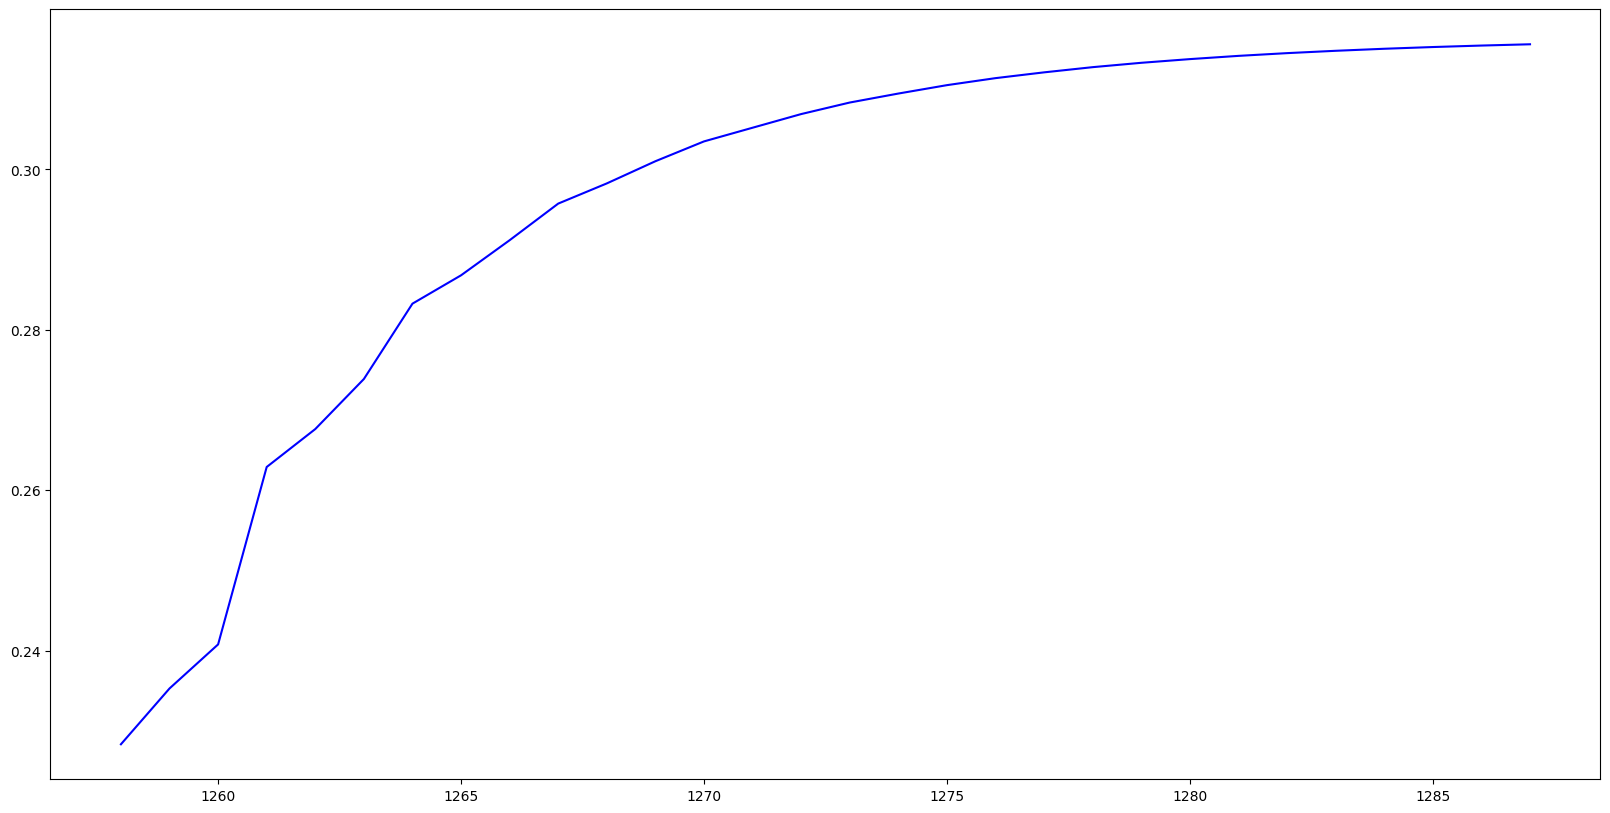

In [18]:
# Tạo mảng index tương ứng với các ngày
days = np.array(range(len(df), len(df) + len(lst_output)))

#vẽ next 30 days
plt.figure(figsize=(20,10))
plt.plot(days, lst_output, c='blue', label='Next 30 days')
plt.show()

In [19]:
#chuẩn hóa ngược lại dữ liệu

train_data_inverse=scaler.inverse_transform(np.array(train_data).reshape(-1, 1))
test_data_inverse=scaler.inverse_transform(np.array(test_data).reshape(-1, 1))
next_30_days_inverse=scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))

# in dữ liệu
print(train_data_inverse[:5])
print(test_data_inverse[:5])
print(next_30_days_inverse[:5])

[[6.04]
 [6.03]
 [5.94]
 [5.87]
 [5.78]]
[[4.08]
 [4.15]
 [4.24]
 [4.28]
 [4.2 ]]
[[3.3743377]
 [3.403432 ]
 [3.426402 ]
 [3.5188897]
 [3.5386696]]


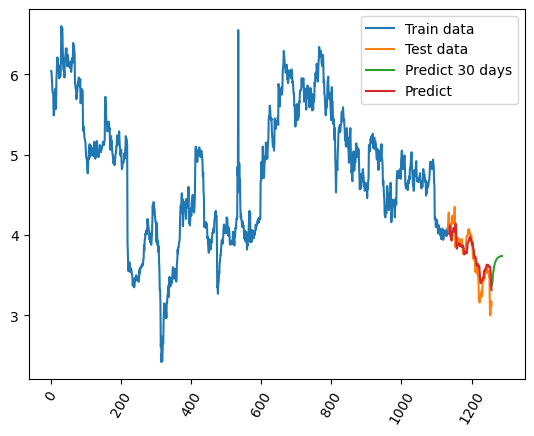

In [20]:
#vẽ y_train nối với ytest và y_val với index tương ứng

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
test_data_index = pd.RangeIndex(start=train_size, stop=len(df1), step=1)
#val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
predict30_data_index = pd.RangeIndex(start=len(df1), stop=len(df1)+30, step=1)

train_predict_index = pd.RangeIndex(start=0, stop=train_predict.shape[0], step=1)
y_pred_index = pd.RangeIndex(start=train_size+(train_size-train_predict.shape[0]), stop=train_size+(train_size-train_predict.shape[0])+y_pred.shape[0], step=1)
#y_pred_val_index = pd.RangeIndex(start=train_size+(train_size-train_predict.shape[0])+y_pred.shape[0]+(val_size-y_pred_val.shape[0]), stop=train_size+(train_size-train_predict.shape[0])+y_pred.shape[0]+y_pred_val.shape[0]+(val_size-y_pred_val.shape[0]), step=1)

plt.plot(train_data_index, train_data_inverse,  label='Train data')
plt.plot(test_data_index, test_data_inverse, label='Test data')
#plt.plot(val_data_index, val_data_inverse,  label='Val data')
plt.plot(predict30_data_index, next_30_days_inverse, label='Predict 30 days')
plt.plot(y_pred_index, y_pred, label='Predict')
#plt.plot(y_pred_val_index, y_pred_val,  label='Val predict')
# trục x là giá trị của cột Close time của df1
#plt.xticks(np.arange(0, len(df1), 100), df['Date'][0:len(df):100])
#xoay ngang giá trị của trục x
plt.xticks(rotation=60)
plt.legend()
plt.show()


